### SRGAN
- 일반적인 GAN에는 없는 특징 추출기가 있어, 생성자가 감별자를 속임과 동시에 진짜 이미지와 비슷한 특징을 갖도록 학습됨
- 합성곱을 한 결과를 저장하여 합성곱을 몇번 더 진행한 결과와 합연산하여 고화질 이미지를 생성


#### 신경망에 원본 더하기가 들어가는 이유
1. 기울기 소실 / 폭주 완화
  - 네트워크가 깊어질수록 역전파 시 기울기가 사라지거나 터지는 현상이 발생
  - Residual Connection은 기울기 경로를 바로 전달해 이런 문제를 줄여줌

2. 학습 안정성 향상
  - 변환이 잘못되더라도 입력을 그대로 통과시킬 수 있어, 망가진 출력보다 나은 최소 보장 성능을 제공
  - 네트워크가 학습하지 않더라도 최소 입력과 비슷한 출력을 낼 수 있으므로 훈련이 덜 망가짐

3. 정보 손실 방지
  - 합성곱 + 활성화 과정에서 정보가 손실될 수 있음
  - 이전의 원본 정보를 더함으로써 손실을 보완

4. 더 깊은 네트워크 설계 가능
  - Residual Connection 덕분에 수백 ~ 수천 레이어도 안정적으로 학습 가능

#### PReLU(Parametric ReLU)
- ReLU 양수에서는 gradient가 1, 음수에서는 0
- 반면 LeakyReLU는 음수에서도 작은 값의 gradient를 가짐
- ReLU와 LeakyReLU 모두 음수의 gradient는 상수 값을 가짐
- PReLU에서는 음수에 대한 gradient를 변수로 두고 학습을 통하여 업데이트

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [18]:
data_root = '/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/SRGAN'

In [46]:
# 입력용 이미지
image_low = 32

# 출력용 이미지
image_high = 64

In [47]:
trans_low = transforms.Compose([transforms.Resize((image_low, image_low)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

trans_high = transforms.Compose([transforms.Resize((image_high, image_high)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

In [48]:
trainlow = torchvision.datasets.ImageFolder(root=data_root, transform=trans_low)
trainhigh = torchvision.datasets.ImageFolder(root=data_root, transform=trans_high)

batch_size = 8

low_loader = DataLoader(trainlow, batch_size=batch_size, shuffle=True)
high_loader = DataLoader(trainhigh, batch_size=batch_size, shuffle=True)

In [49]:
print(len(low_loader))

for images, labels in low_loader:
  break

print(images.shape)
print(labels.shape)

208
torch.Size([8, 3, 32, 32])
torch.Size([8])


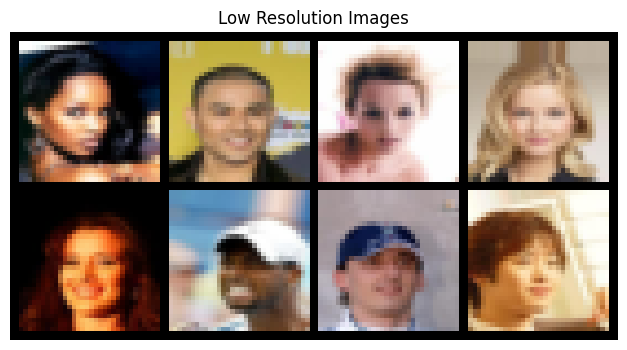

In [50]:
plt.figure(figsize=(10,4))
plt.axis('off')
plt.title('Low Resolution Images')
plt.imshow(np.transpose(vutils.make_grid(images,nrow=4 ,padding=2, normalize=True), (1,2,0)))

In [51]:
print(len(high_loader))

for images, labels in high_loader:
  break

print(images.shape)
print(labels.shape)

208
torch.Size([8, 3, 64, 64])
torch.Size([8])


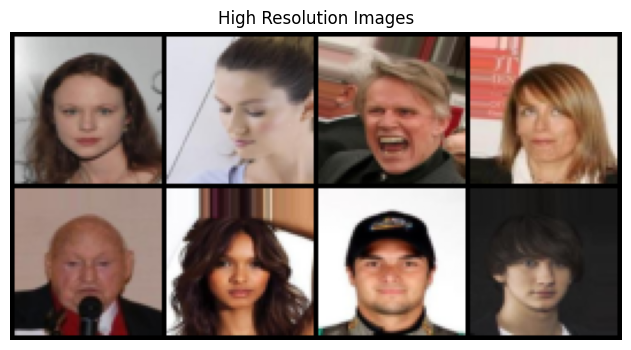

In [52]:
plt.figure(figsize=(10,4))
plt.axis('off')
plt.title('High Resolution Images')
plt.imshow(np.transpose(vutils.make_grid(images,nrow=4 ,padding=2, normalize=True), (1,2,0)))

In [53]:
trans_lowhigh = transforms.Compose([transforms.Resize((image_low, image_low)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    transforms.Resize((image_high, image_high))
                                    ])

trainlowhigh = torchvision.datasets.ImageFolder(root=data_root, transform=trans_lowhigh)
lowhigh_loader = DataLoader(trainlowhigh, batch_size=batch_size, shuffle=True)

for images, labels in lowhigh_loader:
  break

print(images.shape)
print(labels.shape)

torch.Size([8, 3, 64, 64])
torch.Size([8])


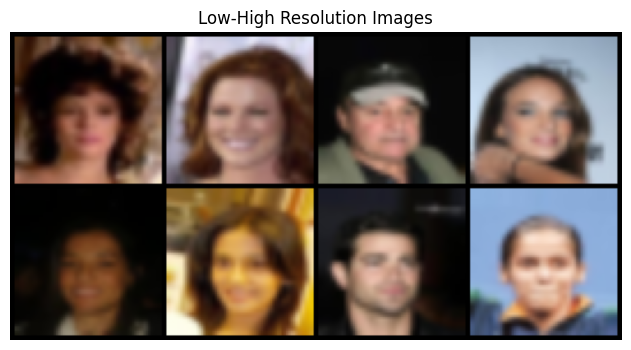

In [54]:
plt.figure(figsize=(10,4))
plt.axis('off')
plt.title('Low-High Resolution Images')
plt.imshow(np.transpose(vutils.make_grid(images,nrow=4 ,padding=2, normalize=True), (1,2,0)))

In [55]:
import glob
from PIL import Image

In [56]:
class CelebA(Dataset):
  def __init__(self):
    self.imgs = glob.glob(data_root + '/img_celeba/*.jpg')

    self.low_res_tf = transforms.Compose([transforms.Resize((image_low, image_low)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])
    self.high_res_tf = transforms.Compose([transforms.Resize((image_high, image_high)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, i):

    img = Image.open(self.imgs[i])
    img_low = self.low_res_tf(img)
    img_high = self.high_res_tf(img)

    return img_low, img_high

In [57]:
dataset = CelebA()
batch_size = 8
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [58]:
class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()

    # 생산자의 구성 요소 정의
    self.layers = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.PReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64)
    )

  def forward(self, x):
    x_old = x
    x = self.layers(x)

    # 합성곱층을 거친 후 원래의 입력 텐서와 더해줌
    return x_old + x

In [59]:
class UpSample(nn.Sequential):
  def __init__(self):
    super(UpSample, self).__init__(
        nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
        nn.PixelShuffle(upscale_factor=2),
        nn.PReLU()
    )

In [60]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # 첫 번째 합성곱층
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
        nn.PReLU()
    )

    # 합성곱 블록
    self.res_blocks = nn.Sequential(
        ResidualBlock(),
        ResidualBlock(),
        ResidualBlock()
    )

    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)

    # 업샘플링층
    self.upsample_blocks = nn.Sequential(
        UpSample()
    )

    # 마지막 합성곱층
    self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

  def forward(self, x):
    x = self.conv1(x)

    x_old = x

    x = self.res_blocks(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x += x_old

    x = self.upsample_blocks(x)

    x = self.conv3(x)

    return x

In [61]:
class DiscBlock(nn.Module):
  def __init__(self):
    super(DiscBlock, self).__init__()

    # 생산자의 구성요소 정의
    self.layers = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU()
    )

  def forward(self, x):
    return self.layers(x)

In [66]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    # 첫 번째 합성곱층
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.LeakyReLU()
    )
    self.blocks = DiscBlock()

    self.fc1 = nn.Linear(64*32*32, 1024)
    self.activation = nn.LeakyReLU()
    self.fc2 = nn.Linear(1024, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.conv1(x)
    x = self.blocks(x)

    x = torch.flatten(x, start_dim=1)

    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.sigmoid(x)

    return x

In [67]:
from torchvision.models.vgg import vgg19

class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor, self).__init__()

    vgg19_model = vgg19(pretrained=True)
    self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:9])

  def forward(self, img):
    return self.feature_extractor(img)

In [68]:
torch.cuda.manual_seed(123)

criterion = nn.BCELoss()

G = Generator().to(device)
D = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)

G_optim = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [70]:
epochs = 25
for epoch in range(epochs):
  for i, (low_res, high_res) in enumerate(loader):
    # 기울기 초기화
    G_optim.zero_grad()
    D_optim.zero_grad()

    b_size = len(high_res)

    # 진짜 이미지와 가짜 이미지의 정답
    label_true = torch.ones(b_size, 1).to(device)
    label_false = torch.ones(b_size, 1).to(device)

    # 생성자 학습
    fake_hr = G(low_res.to(device))
    GAN_loss = criterion(D(fake_hr), label_true)
    # 가짜 이미지 특징 추출
    fake_features = feature_extractor(fake_hr)
    # 진짜 이미지 특징 추출
    real_features = feature_extractor(high_res.to(device))
    # 둘의 차이 비교
    content_loss = nn.L1Loss()(fake_features, real_features)

    loss_G = GAN_loss + content_loss

    loss_G.backward()
    G_optim.step()

    # 판별자 학습
    # 진짜 이미지 손실
    real_loss = criterion(D(high_res.to(device)), label_true)
    # 가짜 이미지 손실
    fake_loss = criterion(D(G(low_res.to(device))), label_false)

    loss_D = (real_loss + fake_loss)/2
    loss_D.backward()
    D_optim.step()

  print(f"Epoch {epoch} of {epochs}")
  print(f"Generator loss: {loss_G:.8f}")

Epoch 0 of 25
Generator loss: 0.38298994
Epoch 1 of 25
Generator loss: 0.39079165
Epoch 2 of 25
Generator loss: 0.34651715
Epoch 3 of 25
Generator loss: 0.31736150
Epoch 4 of 25
Generator loss: 0.29969135
Epoch 5 of 25
Generator loss: 0.25424486
Epoch 6 of 25
Generator loss: 0.26751894
Epoch 7 of 25
Generator loss: 0.29572374
Epoch 8 of 25
Generator loss: 0.30264732
Epoch 9 of 25
Generator loss: 0.27963167
Epoch 10 of 25
Generator loss: 0.25303698
Epoch 11 of 25
Generator loss: 0.27305901
Epoch 12 of 25
Generator loss: 0.21944588
Epoch 13 of 25
Generator loss: 0.25982270
Epoch 14 of 25
Generator loss: 0.25900906
Epoch 15 of 25
Generator loss: 0.25398439
Epoch 16 of 25
Generator loss: 0.25430575
Epoch 17 of 25
Generator loss: 0.25410455
Epoch 18 of 25
Generator loss: 0.28183421
Epoch 19 of 25
Generator loss: 0.20913681
Epoch 20 of 25
Generator loss: 0.22990260
Epoch 21 of 25
Generator loss: 0.21762332
Epoch 22 of 25
Generator loss: 0.22685426
Epoch 23 of 25
Generator loss: 0.25822085
Ep